In [ ]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# 4. Feature Engineering - Numerical

## 4.1. Binning

In [1]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('./data/train.parquet')
df_valid = cudf.read_parquet('./data/valid.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_valid['brand'] = df_valid['brand'].fillna('UNKNOWN')

df_train['cat_0'] = df_train['cat_0'].fillna('UNKNOWN')
df_valid['cat_0'] = df_valid['cat_0'].fillna('UNKNOWN')

df_train['cat_1'] = df_train['cat_1'].fillna('UNKNOWN')
df_valid['cat_1'] = df_valid['cat_1'].fillna('UNKNOWN')

df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')
df_valid['cat_2'] = df_valid['cat_2'].fillna('UNKNOWN')

In [2]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,UNKNOWN,<NA>,2019-12-01 00:00:28,0,0,6,1,12,2019
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:39,0,0,6,1,12,2019
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:40,0,0,6,1,12,2019
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,<NA>,2019-12-01 00:00:41,0,0,6,1,12,2019
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,light,<NA>,2019-12-01 00:01:56,0,1,6,1,12,2019


## Theory

<b>*Binning*</b> maps multiple ordinal categorical or numerical features into groups. It is mainly applied to numerical features:
<li> prevent overfitting by grouping values together
<li> enables us to add some expert knowledge into the model
<li> most simple case: binary flags, e.g. features is greater than 0<br><br>
Examples:<br>
<li> binning weekdays into weekday and weekend
<li> binning hours into morning, early afternoon, late afternoon, evening and night
<li> binning age into child, adlult and retired

We can take a look on the hour of the day. We can see multiple patterns:
<li> 0-3 Night: Low purchase probability 
<li> 4-7 Early morning: Mid purchase probability
<li> 8-14 Morning/Lunch: Higher purchase probability
<li> 15-20 Afternoon: Low purchase probability
<li> 21-23: Evening: High purchase probability

In [3]:
df_train[['ts_hour', 'target']].groupby('ts_hour').agg(['count', 'mean']).head(10)

target          
          count      mean
ts_hour                  
0         58470  0.305319
1         99086  0.252377
2        206718  0.282888
3        386098  0.340300
4        554952  0.372178
5        665547  0.375789
6        729542  0.377133
7        758404  0.383824
8        779388  0.393012
9        779987  0.397358

In [4]:
hour = list(range(0,24))
hour_bin = [0]*4 + [1]*4 + [2]*7 + [3]*6 + [4]*3

data = cudf.DataFrame({
    'hour': hour,
    'hour_bin': hour_bin,
})

In [5]:
data.head(10)

,hour,hour_bin
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
5,5,1
6,6,1
7,7,1
8,8,2
9,9,2


In [6]:
df_train = df_train.merge(data, how='left', right_on='hour', left_on='ts_hour')

In [7]:
df_train[['hour_bin', 'target']].groupby('hour_bin').agg(['count', 'mean'])

target          
            count      mean
hour_bin                   
0          750372  0.310148
1         2708445  0.377661
2         4979563  0.385930
3         2781837  0.337329
4          241140  0.371942

Binning the numerical features reduces the cardinality (# of unique values). Therefore, a model can easier learn the relationship to the target variables, as there are more observation per category. In addition, binning prevents overfitting.

Another reason to apply binning is to standardize numeric variables per category group. The datasets provides information about the product category (cat_1) and price information.

For example, the headphones and smartphones have a different price distribution.
<li> We can probably buy good headphones between $100-$200
<li> For a good smartphone, prices are probably in the range of $400-$1200

Therefore, the buying behavior should be different depending on the price per category (what is a good deal).

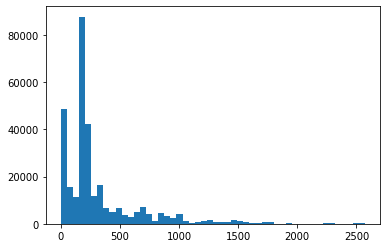

In [8]:
plt.hist(df_train[df_train['cat_2']=='headphone'].price.to_pandas(), bins=50)
plt.show()


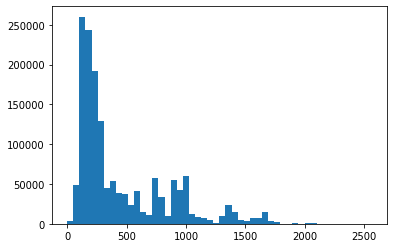

In [9]:
plt.hist(df_train[df_train['cat_1']=='smartphone'].price.to_pandas(), bins=50)
plt.show()


In [10]:
print('Headphones mean price: ' + str(df_train[df_train['cat_2']=='headphone'].price.mean()) + ' median price: ' + str(df_train[df_train['cat_2']=='headphone'].price.median()))
print('Smartphones mean price: ' + str(df_train[df_train['cat_1']=='smartphone'].price.mean()) + ' median price: ' + str(df_train[df_train['cat_1']=='smartphone'].price.median()))

Headphones mean price: 316.9701128768166 median price: 189.82
Smartphones mean price: 456.3495716886366 median price: 263.84


Based on the category tree, we want to bin the prices as a combination of cat_0, cat_1 and cat_2.

In [11]:
df_train['cat_012'] = df_train['cat_0'].astype(str) + '_' + df_train['cat_1'].astype(str) + '_' + df_train['cat_2'].astype(str)

In [12]:
q_list = [0.1, 0.25, 0.5, 0.75, 0.9]

We calculate the quantiles per category group and then merge the quantile to the original dataframe.

In [13]:
for q_value in q_list:
    q = df_train[['cat_012', 'price']].groupby(['cat_012']).quantile(q_value)
    q = q.reset_index()
    q.columns = ['cat_012', 'price' + str(q_value)]
    df_train = df_train.merge(q, how='left', on='cat_012')

Afterwards, we loop through the columns and update the price_bin depending, if the price is between quantiles.

In [14]:
df_train['price_bin'] = -1

for i, q_value in enumerate(q_list):
    if i == 0:
        df_train.loc[df_train['price']<=df_train['price' + str(q_value)], 'price_bin'] = i
    else:
        df_train.loc[(df_train['price']>df_train['price' + str(q_list[i-1])]) & (df_train['price']<=df_train['price' + str(q_value)]), 'price_bin'] = i
        
df_train.loc[df_train['price']>df_train['price' + str(q_value)], 'price_bin'] = i+1

Example output

In [15]:
df_train[df_train['price_bin']==3][['price', 'price0.1', 'price0.25', 'price0.5', 'price0.75', 'price0.9', 'price_bin']].drop_duplicates()

,price,price0.1,price0.25,price0.5,price0.75,price0.9,price_bin
1427700,7.61,4.12,5.56,7.60,11.58,16.99,3
4858449,7.63,4.12,5.56,7.60,11.58,16.99,3
449626,7.68,4.12,5.56,7.60,11.58,16.99,3
138237,7.70,4.12,5.56,7.60,11.58,16.99,3
117511,7.72,3.06,6.15,7.70,12.87,25.71,3
...,...,...,...,...,...,...,...
8098903,766.73,254.81,308.63,514.56,767.81,1283.73,3
5180578,766.82,254.81,308.63,514.56,767.81,1283.73,3
9155543,767.05,254.81,308.63,514.56,767.81,1283.73,3
941982,767.79,254.81,308.63,514.56,767.81,1283.73,3


In [16]:
df_train = df_train.drop(['price' + str(x) for x in q_list])

We can see the pattern, that products in a lower quantile 0-10% and 10-25% have lower purchase probabilities.

In [17]:
df_train[['price_bin', 'target']].groupby('price_bin').agg(['count', 'mean'])

target          
             count      mean
price_bin                   
0          1190744  0.336958
1          1724067  0.359324
2          2844590  0.369048
3          2874795  0.376165
4          1691338  0.375745
5          1135823  0.368033

## Practice

Now, it is your turn. Let's take a look on ts_weekday.<br><br>

**ToDo**:
<li>Analyze ts_weekday and find a good mapping<br>

In [18]:
### ToDo

## Optimization

cuDF has no native binning function (per groupby) implemented, yet. However, cuDF is constantly developing and new features get implemented. Stay tuned to get the latest updates.<br><br>
We can improve our above implementation. Currently, we calculate all binnings and merge them to the original dataframe. That requires more memory. We need only consecutive quantile columns.

We restart the kernel.

In [25]:
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [2]:
import IPython

import pandas as pd
import cudf
import numpy as np
import cupy
import matplotlib.pyplot as plt

df_train = cudf.read_parquet('./data/train.parquet')

df_train['brand'] = df_train['brand'].fillna('UNKNOWN')
df_train['cat_0'] = df_train['cat_0'].fillna('UNKNOWN')
df_train['cat_1'] = df_train['cat_1'].fillna('UNKNOWN')
df_train['cat_2'] = df_train['cat_2'].fillna('UNKNOWN')

In [3]:
df_train['cat_012'] = df_train['cat_0'].astype(str) + '_' + df_train['cat_1'].astype(str) + '_' + df_train['cat_2'].astype(str)

In [4]:
def group_binning(df, q_list = [0.1, 0.25, 0.5, 0.75, 0.9]):
    df['price_bin'] = -1
    
    for i, q_value in enumerate(q_list):
        print(q_value)
        q = df[['cat_012', 'price']].groupby(['cat_012']).quantile(q_value)
        q = q.reset_index()
        q.columns = ['cat_012', 'price' + str(q_value)]
        df = df.merge(q, how='left', on='cat_012')
        if i == 0:
            df.loc[df['price']<=df['price' + str(q_value)], 'price_bin'] = i
        else:
            df.loc[(df['price']>df['price' + str(q_list[i-1])]) & (df['price']<=df['price' + str(q_value)]), 'price_bin'] = i
        if i>=2:
            df.drop(['price' + str(q_list[i-2])], axis=1, inplace=True)
            
    df.loc[df['price']>df['price' + str(q_value)], 'price_bin'] = i+1
    df.drop(['price' + str(q_list[i-1])], axis=1, inplace=True)
    df.drop(['price' + str(q_list[i])], axis=1, inplace=True)
    return(df)

In [5]:
df_train_pd = df_train.to_pandas()

In [6]:
%%time

df_train_pd = group_binning(df_train_pd)

0.1
0.25
0.5
0.75
0.9
CPU times: user 1min 26s, sys: 41.5 s, total: 2min 8s
Wall time: 2min 8s


In [7]:
%%time

df_train = group_binning(df_train)

0.1
0.25
0.5
0.75
0.9
CPU times: user 3.61 s, sys: 3.32 s, total: 6.93 s
Wall time: 6.62 s


In [8]:
df_train.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,...,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year,cat_012,price_bin
0,2019-12-01 07:51:27 UTC,cart,1004781,huawei,247.27,569317987,3c378a32-dd69-4e1b-8251-2cfa0f831cd6,0,construction,tools,...,<NA>,2019-12-01 07:51:27,7,51,6,1,12,2019,construction_tools_light,3
1,2019-12-01 07:51:34 UTC,cart,2401055,turbo,47.88,517451347,d3b2e38b-5d13-4b60-857c-f79f5674686b,0,appliances,kitchen,...,<NA>,2019-12-01 07:51:34,7,51,6,1,12,2019,appliances_kitchen_hood,2
2,2019-12-01 07:51:36 UTC,cart,1004856,samsung,124.10,580108461,f272b88b-0dcf-48b8-a466-7398dcda9d3b,0,construction,tools,...,<NA>,2019-12-01 07:51:36,7,51,6,1,12,2019,construction_tools_light,0
3,2019-12-01 07:51:36 UTC,cart,1004751,samsung,192.77,545521992,686fc0f9-193e-4f81-95ec-02552cd596fe,0,construction,tools,...,<NA>,2019-12-01 07:51:36,7,51,6,1,12,2019,construction_tools_light,2
4,2019-12-01 07:51:37 UTC,cart,1801906,tcl,231.13,552287591,681fbfd6-d352-4f3e-8ba6-5219bc0d3071,0,appliances,personal,...,<NA>,2019-12-01 07:51:37,7,51,6,1,12,2019,appliances_personal_massager,2


In our experiments, we achieve a speed up of 28.2x.

We shutdown the kernel.

In [9]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}